In [13]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/wyattscott/Documents/DS5110/Project')

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")
df_selected = pd.read_csv('df_selected.csv')

In [15]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert y_train and y_test to arrays
y_train = y_train.values
y_test = y_test.values

# Convert X_train_selected and X_test_selected to arrays
X_train = X_train_selected.values
X_test = X_test_selected.values

---

# OLS

In [16]:
# Initialize a linear regression model
linear_model = LinearRegression()

# Fit the model on the preprocessed training data
linear_model.fit(X_train, y_train)

# Make predictions on the test data using the model fitted on selected features
y_pred_ols = linear_model.predict(X_test)

# Evaluate the model using mean squared error and R-squared on selected features
test_mse_ols = mean_squared_error(y_test, y_pred_ols)
test_r2_ols = r2_score(y_test, y_pred_ols)

print("Test MSE (OLS):", test_mse_ols)
print("Test R-squared (OLS):", test_r2_ols)

Test MSE (OLS): 0.0043337575247560335
Test R-squared (OLS): 0.40214118058188875


In [17]:
# Get the coefficients and corresponding feature names
coefficients = linear_model.coef_
feature_names = df_selected.columns

# Match coefficients with corresponding feature names
coefficients_dict = dict(zip(feature_names, coefficients))

# Print feature importance
print("Feature Coefficients (OLS):")
for feature, coefficient in coefficients_dict.items():
    print(feature, ":", coefficient)

Feature Coefficients (OLS):
VORP : 0.06497139040849774
PER : 0.005175556320153947
WS : -0.00614614502097844
FT : -0.00125882941190273
BPM : -0.026424555406396825
Rk_Conference : -0.0020087599371607563
USG% : -0.00038376730225571793
Trp Dbl : 1.2642363531935008
AST : -0.006758617791088807
2P% : -0.06319943024831641


---

# Random Forest

In [18]:
# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf,
                                      n_iter=50, scoring='r2', cv=10, random_state=28)

# Perform random search
random_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = random_search_rf.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

# Make predictions on the test data using the best model
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
test_r2_rf = r2_score(y_test, y_pred_rf)

print("Test MSE (Best Random Forest):", test_mse_rf)
print("Test R-squared (Best Random Forest):", test_r2_rf)

Best Hyperparameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Test MSE (Best Random Forest): 0.0022110990526614483
Test R-squared (Best Random Forest): 0.6949702281012837


In [19]:
# Get feature importance
feature_importance_rf = best_rf_model.feature_importances_

# Match feature importance with corresponding feature names
feature_importance_dict_rf = dict(zip(feature_names, feature_importance_rf))

# Sort feature importance in descending order
sorted_feature_importance_rf = sorted(feature_importance_dict_rf.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance (Random Forest):")
for feature, importance in sorted_feature_importance_rf:
    print(feature, ":", importance)

Feature Importance (Random Forest):
WS : 0.24416368335941693
PER : 0.20019191008735335
VORP : 0.1567921055509965
BPM : 0.12153468995880429
Rk_Conference : 0.09963184911922522
USG% : 0.0620281324433072
AST : 0.03538159748252566
FT : 0.034148522447333046
Trp Dbl : 0.02322937216203309
2P% : 0.02289813738900458


---

# Gradient Boosting Regressor

In [20]:
# Define the hyperparameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.15],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'max_features': ['auto', 'sqrt']  # Number of features to consider when looking for the best split
}

# Initialize GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb,
                                      n_iter=50, scoring='r2', cv=10, random_state=28)

# Perform random search
random_search_gb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_gb = random_search_gb.best_params_
print("Best Hyperparameters (Gradient Boosting):", best_params_gb)

# Get the best model
best_gb_model = random_search_gb.best_estimator_

# Make predictions on the test data using the best model
y_pred_gb = best_gb_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_gb = mean_squared_error(y_test, y_pred_gb)
test_r2_gb = r2_score(y_test, y_pred_gb)

print("Test MSE:", test_mse_gb)
print("Test R-squared:", test_r2_gb)

Best Hyperparameters (Gradient Boosting): {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.15}
Test MSE: 0.0024566710985349117
Test R-squared: 0.6610926028328364


In [21]:
# Get feature importance
feature_importance_gb = best_gb_model.feature_importances_

# Match feature importance with corresponding feature names
feature_importance_dict_gb = dict(zip(feature_names, feature_importance_gb))

# Sort feature importance in descending order
sorted_feature_importance_gb = sorted(feature_importance_dict_gb.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance (Gradient Boosting):")
for feature, importance in sorted_feature_importance_gb:
    print(feature, ":", importance)

Feature Importance (Gradient Boosting):
PER : 0.31958455150861165
WS : 0.21052442377940903
BPM : 0.1352737511472747
Rk_Conference : 0.10581671319607845
VORP : 0.06380877377371832
AST : 0.05270518402360628
USG% : 0.0468093227239498
Trp Dbl : 0.022965991753079236
2P% : 0.022889578327088902
FT : 0.0196217097671837


---

## XGBoost Regressor

In [22]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1, 0.15],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
}

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=50, scoring='r2', cv=5, random_state=28)

# Perform random search
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_xgb = mean_squared_error(y_test, y_pred_xgb)
test_r2_xgb = r2_score(y_test, y_pred_xgb)

print("Test MSE (Best XGBoost):", test_mse_xgb)
print("Test R-squared (Best XGBoost):", test_r2_xgb)

Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 1.0}
Test MSE (Best XGBoost): 0.0024751768305487304
Test R-squared (Best XGBoost): 0.6585396646421211


In [23]:
# Get feature importance
feature_importance = best_xgb_model.feature_importances_

# Match feature importance with corresponding feature names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(feature, ":", importance)

Feature Importance:
PER : 0.31508783
WS : 0.27140173
Rk_Conference : 0.09708833
BPM : 0.092239715
AST : 0.048358127
VORP : 0.045987107
FT : 0.03787918
2P% : 0.034811873
USG% : 0.02876429
Trp Dbl : 0.028381841


---

## Multilayer Perceptron

In [24]:
# Define the hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Number of neurons in each hidden layer
    'activation': ['relu'],  # Activation function for the hidden layers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'max_iter': [300, 400, 500],  # Maximum number of iterations
}

# Initialize MLPRegressor
mlp_model = MLPRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(estimator=mlp_model, param_distributions=param_grid_mlp,
                                       n_iter=50, scoring='r2', cv=10, random_state=28)

# Perform random search
random_search_mlp.fit(X_train, y_train)

# Get the best hyperparameters
best_params_mlp = random_search_mlp.best_params_
print("Best Hyperparameters (MLP):", best_params_mlp)

# Get the best model
best_mlp_model = random_search_mlp.best_estimator_

# Make predictions on the test data using the best model
y_pred_mlp = best_mlp_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_mlp = mean_squared_error(y_test, y_pred_mlp)
test_r2_mlp = r2_score(y_test, y_pred_mlp)

print("Test MSE (Best MLP):", test_mse_mlp)
print("Test R-squared (Best MLP):", test_r2_mlp)

Best Hyperparameters (MLP): {'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'relu'}
Test MSE (Best MLP): 0.003015790903818793
Test R-squared (Best MLP): 0.5839598364538214


---

# Model Comparisons

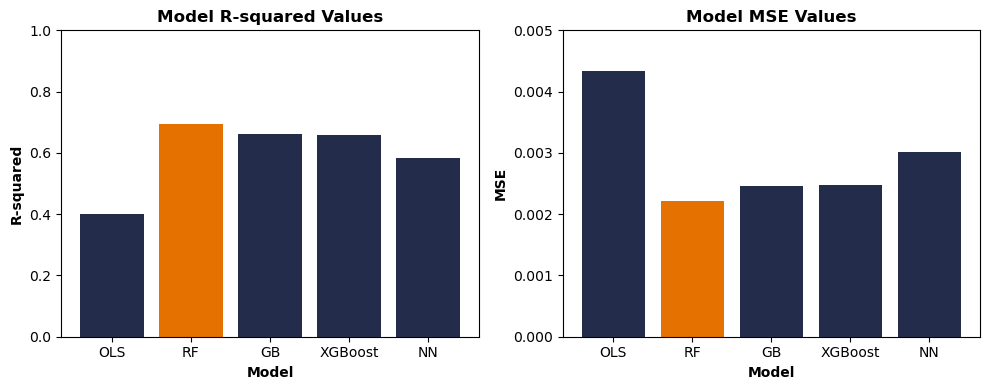

In [25]:
# Data for R-squared values
r_sqs = [test_r2_ols, test_r2_rf, test_r2_gb, test_r2_xgb, test_r2_mlp]

# Data for MSE values
MSE_s = [test_mse_ols, test_mse_rf, test_mse_gb, test_mse_xgb, test_mse_mlp]

# List of model names
model_names = ['OLS', 'RF', 'GB', 'XGBoost', 'NN']

# Determine colors for R-squared bars
r_sq_colors = ['#E57200' if r == max(r_sqs) else '#232D4B' for r in r_sqs]

# Determine colors for MSE bars
mse_colors = ['#E57200' if mse == min(MSE_s) else '#232D4B' for mse in MSE_s]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the R-squared values
axs[0].bar(model_names, r_sqs, color=r_sq_colors)
axs[0].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_ylabel('R-squared', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_title('Model R-squared Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_ylim(0, 1)  # Set the y-axis limit to be between 0 and 1

# Plot the MSE values
axs[1].bar(model_names, MSE_s, color=mse_colors)
axs[1].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_ylabel('MSE', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_title('Model MSE Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[1].tick_params(axis='x', rotation=0)
axs[1].set_ylim(0, 0.005)  # Set the y-axis limit to be between 0 and 0.005

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()